'image_name', 'prompt', 'part_id', 'seed', 'step', 'cfg', 'sampler', 'width', 'height', 'user_name', 'timestamp', 'image_nsfw', 'prompt_nsfw', 'clip_emb'

In [1]:
from PromptDatasetManager import PromptDatasetManager
manager = PromptDatasetManager()

manager.load_local_metadata(
    path="/Users/tella/Workspace/Inria/Data/normalized_embeddings.parquet",
    max_rows=10000, # Limita per testare velocemente
    add_columns=['part_id', 'image_name']
)
print(f"Colonne disponibili: {list(manager.df.columns)}")
# Print the last part column of last row
print(manager.df.iloc[-1]['part_id'])

Colonne disponibili: ['prompt', 'clip_emb', 'user_name', 'timestamp', 'part_id', 'image_name']
10


In [ ]:
import zipfile
from pathlib import Path
from PIL import Image
import pandas as pd
from IPython.display import display

ZIP_DIR = Path("/Volumes/One Touch/Data")

def estrai_immagine_da_riga(row):
    part_id = int(row['part_id'])
    image_name = row['image_name']
    
    # Nome ZIP con zeri iniziali: part-00001.zip
    zip_filename = f"part-{part_id:06}.zip"
    zip_path = ZIP_DIR / zip_filename

    # Carica immagine da ZIP e mostra inline
    with zipfile.ZipFile(zip_path, 'r') as archive:
        with archive.open(image_name) as file:
            return Image.open(file).convert("RGB")


PROMPT: a portrait of a female robot made from code, very intricate details, octane render, 8 k, trending on artstation 


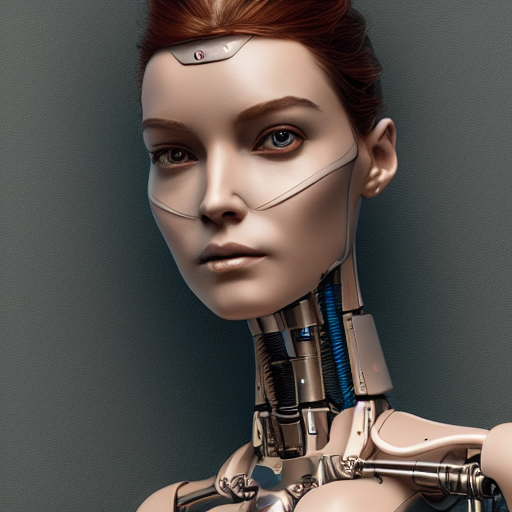

In [3]:
# Get first image ddata from the DataFrame
first_image_row = manager.df.iloc[0]
print(f"PROMPT: {first_image_row['prompt']}")
estrai_immagine_da_riga(first_image_row)

In [ ]:
import torch
import clip
import random
import numpy as np

# Select random image and get its data
# First make sure CLIP is imported and model is loaded

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Select random image and get its data
random_idx = random.randint(0, len(manager.df) - 1)
random_row = manager.df.iloc[random_idx]

# Display the image and prompt
print(f"Selected prompt: {random_row['prompt']}")
img = estrai_immagine_da_riga(random_row)
display(img)

# Get prompt embedding from the dataset
prompt_embedding = manager.emb_matrix[random_idx]

# Calculate image embedding using CLIP
# Preprocess image for CLIP
image_input = preprocess(img).unsqueeze(0).to(device)

with torch.no_grad():
    # Get image features
    image_features = model.encode_image(image_input)
    # Normalize features
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    
    # Convert to numpy for comparison
    image_embedding = image_features.cpu().numpy()[0]

# Calculate cosine similarity between prompt and image embeddings
similarity = np.dot(prompt_embedding, image_embedding)
print(f"\nCosine similarity with itself (should be 1.0): {similarity:.4f}")


## Sampled Image: 
### an anatomically correct human heart textured like a raspberry, shiny, octane render 


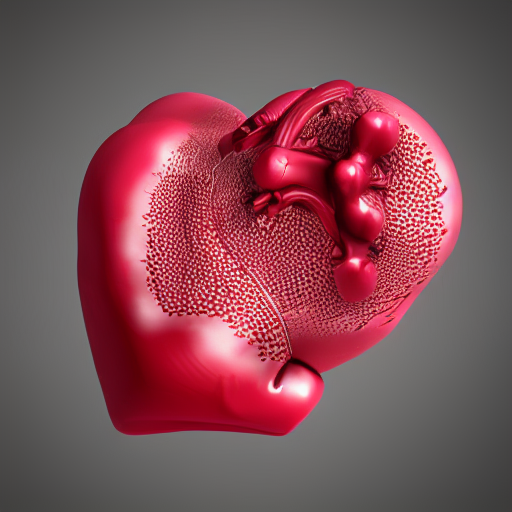

## 1. Similarità: 0.9555 
 ### a cybertronic anatomically correct human heart textured like a raspberry and made of metal, octane render


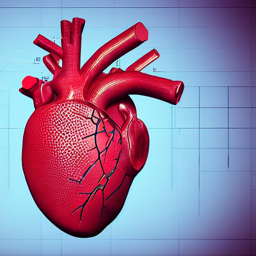

## 2. Similarità: 0.8694 
 ### an anatomically correct cybertronic human heart, biomechanical, made of metal, reflective, octane render


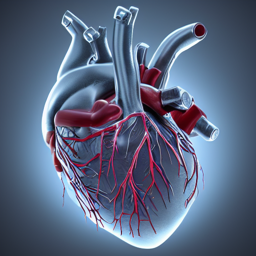

## 3. Similarità: 0.8694 
 ### an anatomically correct cybertronic human heart, biomechanical, made of metal, reflective, octane render


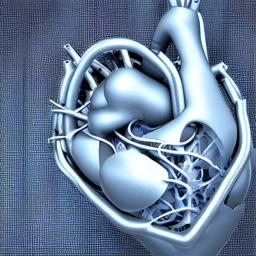

In [4]:
import random
from typing import Tuple
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import faiss
import numpy as np

def faiss_search_similarity(
    index: faiss.IndexFlatIP,
    query: np.ndarray,
    topk: int = 10
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Esegue una ricerca di similarità usando FAISS.
    Ritorna le distanze e gli indici dei top-k risultati.
    La ricerca la fa su tutto il dataset indicizzato.
    - index: istanza di faiss.IndexFlatIP indicizzata
    - query: vettore di query (1D o 2D con una riga)
    - topk: numero di risultati da restituire
    """
    query = query.reshape(1, -1).astype(np.float32)
    distances, indices = index.search(query, topk)
    return distances[0], indices[0]

import matplotlib.pyplot as plt

def mostra_prompt_simili_con_immagini_faiss(self, index: faiss.Index, topk: int = 6):
    # 1. Scegli un prompt a caso
    idx_random = random.randint(0, len(self.df) - 1)
    riga = self.df.iloc[idx_random]

    prompt_query = riga['prompt']
    query_emb = self.emb_matrix[idx_random]

    display(Markdown(f"\n## Sampled Image: \n### {prompt_query}\n"))

    # Mostra l'immagine del prompt selezionato
    img_query = estrai_immagine_da_riga(riga)
    display(img_query)

    # 2. Cerca simili con FAISS
    distances, indices = faiss_search_similarity(index, query_emb, topk=topk + 1)  # +1 per includere se stesso

    # Rimuovi il primo risultato (se stesso)
    distances = distances[1:]
    indices = indices[1:]

    for rank, (idx, dist) in enumerate(zip(indices, distances), 1):
        r_sim = self.df.iloc[idx]
        prompt_sim = r_sim['prompt'].strip().replace("\n", " ")

        display(Markdown(f"## {rank}. Similarità: {dist:.4f} \n ### {prompt_sim}\n"))

        img_sim = estrai_immagine_da_riga(r_sim).resize((256, 256))
        display(img_sim)

dim = manager.emb_matrix.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(manager.emb_matrix.astype(np.float32))
mostra_prompt_simili_con_immagini_faiss(manager, index, topk=3)

In [ ]:
from numpy import shape


raws = manager.get_k_nearest_images(row_index=0, k=3)

print(len(raws))
print(len(raws[0]))
for raw in raws:
    img = estrai_immagine_da_riga(raw)
    display(img.resize((256, 256)))

2
4


TypeError: cannot convert the series to <class 'int'>